<a href="https://colab.research.google.com/github/chrishalkias/NNSTM/blob/main/RegressNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
from sklearn.datasets import fetch_openml
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats.kde as kde
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from time import time
from scipy.stats import gaussian_kde
from keras import backend as K

# RegressNIST

In this notebook we turn MNIST classification into a regression problem.
We create a function to gather the mnist dataset and then andother function to create centered Gaussians around the label. Then an ensemble of untrained networks is compared with one of trained ones.

## Setup

In [ ]:
def fetch_mnist():
  '''Loads the MNIST dataset'''
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

  return x_train, y_train, x_test, y_test

def transform_label_to_gaussian(y: int, array_size=784, std_dev=1.0) -> np.array((1,178)):
  '''  Transforms a label y into a 784-dimensional Gaussian array.  '''
  x_values = np.linspace(0, 9, array_size)
  gaussian_array = norm.pdf(x_values, loc=y, scale=std_dev)
  gaussian_array /= gaussian_array.sum()
  return gaussian_array

Call the functions and transform the labels.

In [ ]:
X, y, X_test, y_test = fetch_mnist()
y_transformed = np.array([transform_label_to_gaussian(label, std_dev = 0.001) for label in y])
y_test_transformed = np.array([transform_label_to_gaussian(label, std_dev = 0.001) for label in y_test])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Create a function that plots the overlapping Gaussians for each label (good visualization to see what stdev is good).

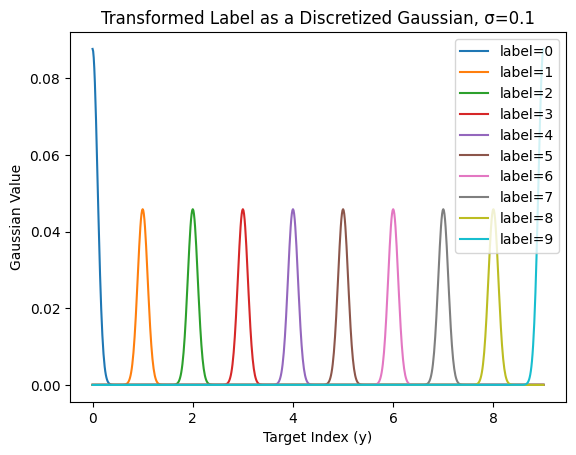

In [ ]:
def g_tester(y_transformed: np.array) -> plt.plot:
  x_axis = np.linspace(0,9,784)
  std_dev=0.1
  for label in range(0,10):
    array = transform_label_to_gaussian(label, std_dev=std_dev)
    plt.plot(x_axis, array, label=f'label={label}')
  plt.title(f"Transformed Label as a Discretized Gaussian, σ={std_dev}")
  plt.xlabel("Target Index (y)")
  plt.ylabel("Gaussian Value")
  plt.legend()
  plt.savefig('gaussian.png')
  plt.show()

g_tester(y_transformed)

Now create a FCN from scratch that takes as an input X and ouputs $y^*$.

In [ ]:
class SimpleFullyConnectedNetwork:
    def __init__(self, T=1,  input_size=784, linear=True, g=0):
        # Initialize weights and biases for two layers
        self.temp = T
        self.lin = linear
        self.g = g
        self.W1 = np.random.randn(input_size, input_size) * T/input_size
        self.W2 = np.random.randn(input_size, 1) * T/input_size

    def relu(self, x, g=0.01):
        return g*np.sum(x)**3

    def net(self, x):
        # Forward pass through the two layers
        x = x.flatten()  # Flatten the image
        z1 = np.dot(x, self.W1)# First layer linear transformation
        a1 = self.relu(z1)  # Apply ReLU activation
        z2 = np.dot(a1, self.W2)# Second layer linear transformation
        if self.lin == False:
          return self.g*z2**3
        elif self.lin == True:
          return z2

A function that calls the network class multiple times to gen ensemble statistics.

In [ ]:
def untrained_net(ensemble_size=100, temperature=0.1, neuron = 0, mu=0, linear = True):
  global output_list
  output_list = []
  for iterations in range(ensemble_size):
    network = SimpleFullyConnectedNetwork(T=temperature, linear = linear)
    sample_image = X[mu].flatten()
    output = network.net(sample_image)
    output_list.append(np.linalg.norm(output))
    # print(f"Output for the sample image: {output}")
  s = pd.Series(output_list)
  plt.plot(s, 'gx')
  plt.title(f'Outputs of {ensemble_size} untrained NNs for T={temperature}')
  plt.xlabel('Network Index')
  plt.ylabel(f'Output')
  plt.ylim(-10, 10)
  plt.savefig(f'T={temperature}.png')
  plt.show()
  print()
  s.plot.kde(bw_method=1)
  plt.title(f'Gaussian KDE of outputs at T={temperature}')
  plt.xlim(-1, 1)
  plt.savefig(f'Gaussian_kde_(T={temperature}).png')
  plt.show()

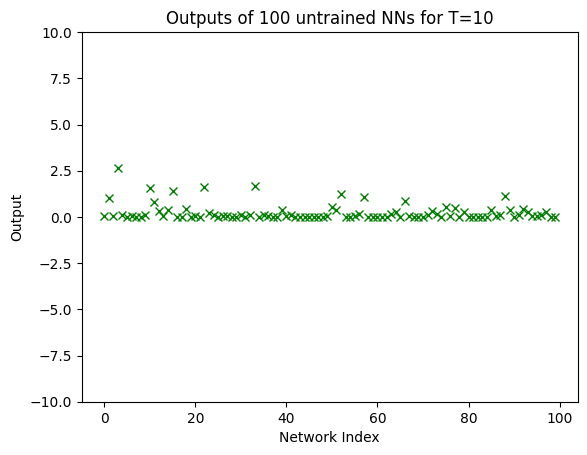

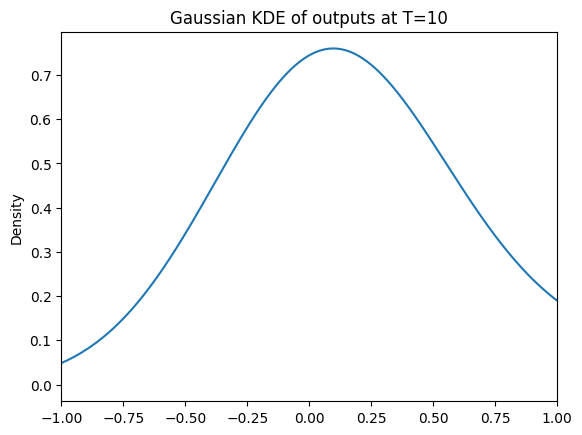

In [ ]:
untrained_net(ensemble_size=100, temperature = 10)

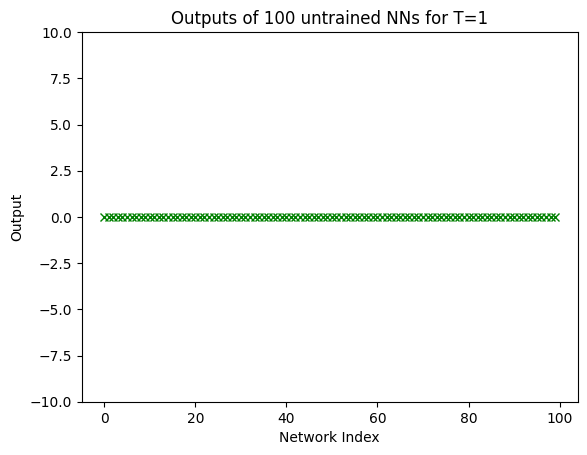

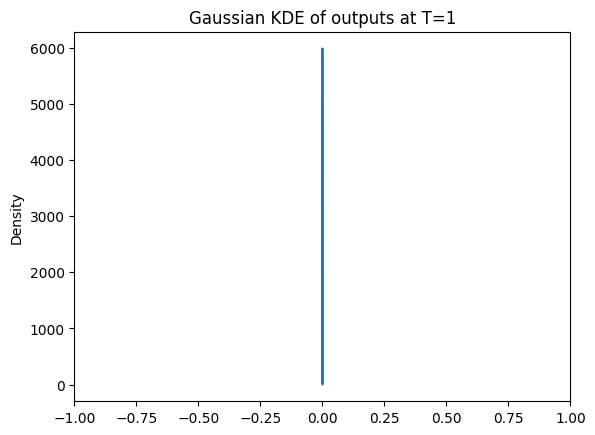

In [ ]:
untrained_net(ensemble_size=100, temperature = 1)

Now for a non-linear

## Train

Now lets build a keras network and backpropagate to find the optimal weight configuration.

In [ ]:
def regress(epochs, g):
  sigma_over_N = float(1/784)
  model = keras.models.Sequential()
  init = keras.initializers.RandomNormal(stddev=sigma_over_N)
  flatten = keras.layers.Flatten(input_shape=[28,28])
  model.add(flatten)
  model.add(keras.layers.Dense(units=784, activation='linear', use_bias=False, kernel_regularizer=keras.regularizers.L2(l2=1e-4), name='linear_layer'))
  readout_layer = keras.layers.Dense(units=784, activation =lambda x: x+g*x**3, use_bias=False,kernel_regularizer=keras.regularizers.L2(l2=1e-4), name='readout_layer')
  readout_layer.trainable=True
  model.add(readout_layer)
  #---compile---
  t0 = time()
  model_summary, model_layers  = model.summary(), model.layers
  opt = tf.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(loss='mse', optimizer = opt, metrics=["kl_divergence", "accuracy"])
  history = model.fit(X, y_transformed, epochs=epochs, validation_data =(X_test,y_test_transformed), verbose=1)
  print(f'total runtime {int(time()-t0)/60} minutes')
  model.save('/content/my_model.keras')
  return model, history

Plot the metrics as a function of epochs

In [ ]:
def gather_g_performance_list():
  result_list = []
  for g in [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]:
    model, history = regress(epochs = 2, g=g)
    result_list.append({'g': g, 'accuracy' :history.history['accuracy'], 'val_accuracy' :history.history['val_accuracy']})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ linear_layer (Dense)                 │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ readout_layer (Dense)                │ (None, 784)                 │         614,656 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,229,312 (4.69 MB)

 Trainable params: 1,229,312 (4.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.0027 - kl_divergence: 7.2467 - loss: 0.2460 - val_accuracy: 0.0195 - val_kl_divergence: 4.6237 - val_loss: 0.2020
Epoch 2/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.0342 - kl_divergence: 4.1891 - loss: 0.1981 - val_accuracy: 0.0869 - val_kl_divergence: 3.3136 - val_loss: 0.1883
Epoch 3/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.0989 - kl_divergence: 3.1177 - loss: 0.1865 - val_accuracy: 0.1621 - val_kl_divergence: 2.5926 - val_loss: 0.1804
Epoch 4/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.1765 - kl_divergence: 2.5057 - loss: 0.1792 - val_accuracy: 0.2323 - val_kl_divergence: 2.1553 - val_loss: 0.1748
Epoch 5/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.2416 - kl_divergence: 2.1139 - loss: 0.1739 - val_accuracy: 0.2971 - val_kl_divergence: 1.8874 - val_loss: 0.1704
Epoch 6/60
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.3012 - kl_

/usr/local/lib/python3.11/dist-packages/keras/src/activations/__init__.py:76: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:   readout_layer = keras.layers.Dense(units=784, activation =lambda x: x+g*x**3, use_bias=False,kernel_regularizer=keras.regularizers.L2(l2=1e-4), name='readout_layer')

  fn_config = serialization_lib.serialize_keras_object(activation)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


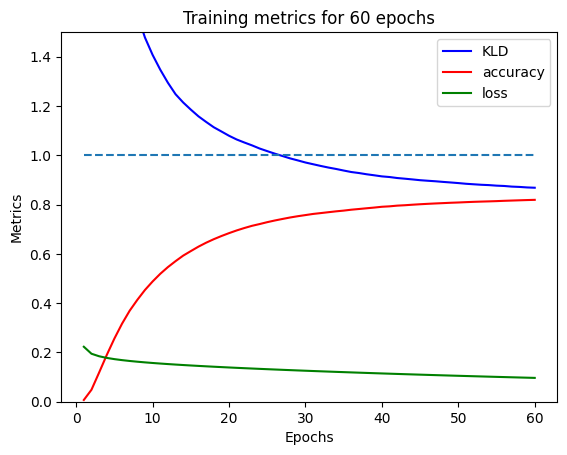

In [ ]:
try:
  model, history = regress(epochs = 60, g=0.7)
  prediction = np.array(model.predict(X))
  loss = history.history['loss']
  kld = history.history['kl_divergence']
  acc = history.history['accuracy']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, kld, 'b', label='KLD')
  plt.plot(epochs, acc, 'r', label='accuracy')
  plt.plot(epochs, np.ones_like(loss), '--')
  plt.plot(epochs, loss, 'g', label='loss')
  plt.ylim(0,1.5)
  plt.xlabel('Epochs')
  plt.ylabel('Metrics')
  plt.title(f'Training metrics for {len(epochs)} epochs')
  plt.legend()
  plt.savefig('lin.png')
  plt.show()
except:
  model = keras.models.load_model("100_epochs_lin.keras") #load the model if saved
  prediction = np.array(model.predict(X))

Save the model and predict.

Compare the model predictions with the actual (transformed) label

In [ ]:
print('Epochs:', len(history.history['accuracy']))
for key in history.history.keys():
  final_val = history.history[key][-1]
  print(f'final {key}: {final_val}')

Epochs: 60
final accuracy: 0.8192999958992004
final kl_divergence: 0.8684430718421936
final loss: 0.09671808034181595
final val_accuracy: 0.8291000127792358
final val_kl_divergence: 0.8198758959770203
final val_loss: 0.09625156223773956


In [ ]:
def plot(tests = 1):
  '''plots {tests} instances of the comparison'''
  for mu in [random.randint(0,len(X_test)) for _ in range(tests)]:
    plt.imshow(X_test[mu])
    plt.title(f'Image of digit {y_test[mu]}')
    plt.show()
    error_squared = round(0.5 * np.power((prediction[mu]-y_test_transformed[mu]).sum(), 2), 3)
    print(f'Prediction Error: {error_squared}')
    digit_space = np.linspace(0,9,784)
    plt.title(f'Trained network prediction for the digit {y_test[mu]}')
    plt.plot(digit_space, prediction[mu], 'b', label = 'Prediction')
    plt.plot(digit_space, y_test_transformed[mu], 'ro', label = 'Target')
    plt.ylim(0,1.1)
    plt.xticks(np.arange(0, 10, step=1))
    plt.legend()
    plt.savefig(f'pred_{mu}[{y_test[mu]}].png')
    plt.show()

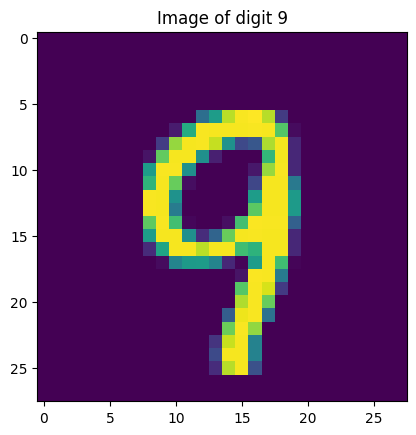

Prediction Error: 0.187


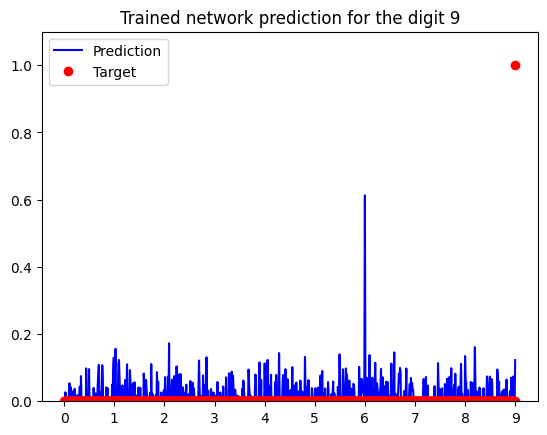

In [ ]:
plot(tests = 1)